In [1]:
import torch
import torchviz
import os
import torch.nn as nn
import pandas as pd
import numpy as np      
from sklearn.model_selection import train_test_split
import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve


In [2]:
# import dataset
df = pd.read_csv("../3 - Cleaning & Transforming Data/2 cleaned_dataset_MERGED_DRUG(Mogran)_ALLELESEQ.csv", index_col = None)

if(df.isna().any().sum()) != 0:
    raise Exception('There are still missing values in the dataset!')

In [7]:
df.iloc[:,2060:3000].head()

,2046,2047,Unnamed: 0,p1-0--,p1-0-A,p1-0-C,p1-0-D,p1-0-E,p1-0-F,p1-0-G,...,p1-44-D,p1-44-E,p1-44-F,p1-44-G,p1-44-H,p1-44-I,p1-44-K,p1-44-L,p1-44-M,p1-44-N
0,0,0,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.iloc[:,2:6].value_counts()

ADR_MPeruption  ADR_MPexanthema  ADR_SJS  ADR_TEN
0               0                0        0          8438
                                 1        0          2069
                                 0        1          1382
                1                0        0           667
1               0                0        0           517
dtype: int64

In [4]:
df['ADR'].value_counts()

SJS            5805
TEN            3738
MPexanthema    1896
MPeruption     1634
Name: ADR, dtype: int64

In [5]:
# Drop unnecessary columns
df_stratify = pd.DataFrame()
df['ADR'] = df['ADR'].replace({'SJS': 0, 'TEN': 1, 'MPexanthema':2,'MPeruption':3})
#df = df[df['ADR'].isin([0,1])] #ลบ MP ออก
df_stratify['ADR'] = df['ADR'].copy()
df.drop(columns=['No_ADR','ADR','ADR_MPeruption','ADR_MPexanthema','ADR_SJS','ADR_TEN','Cohort ethnicity','Allele','Drug'], inplace=True)

In [6]:
df = pd.concat([df_stratify,df],axis=1)
df.rename(columns={'ADR':'ADR_TRACK'}, inplace=True)

In [7]:
df.iloc[:,2050:2065]

,2044,2045,2046,2047,Unnamed: 0,p1-0--,p1-0-A,p1-0-C,p1-0-D,p1-0-E,p1-0-F,p1-0-G,p1-0-H,p1-0-I,p1-0-K
0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13068,0,0,0,0,64,0,0,0,0,0,0,0,0,0,0
13069,0,0,0,0,64,0,0,0,0,0,0,0,0,0,0
13070,0,0,0,0,83,0,0,0,0,0,0,0,0,0,0
13071,0,0,0,0,38,0,0,0,0,0,0,0,0,0,0


In [8]:
df['ADR_TRACK'].value_counts()

0    5805
1    3738
2    1896
3    1634
Name: ADR_TRACK, dtype: int64

In [9]:
# Select output columns and drop unnecessary columns
df_output = df['Yes_ADR'].copy()
df.drop(columns = ['Yes_ADR'], inplace = True)
df_input = df.copy()
# Check input dtypes
df_input.dtypes.value_counts()

int64    4364
dtype: int64

In [10]:
df_input

,ADR_TRACK,Cohort ethnicity_Black,Cohort ethnicity_Caucasian,Cohort ethnicity_Diverse,Cohort ethnicity_Mongol,0,1,2,3,4,...,p2-54-M,p2-54-N,p2-54-P,p2-54-Q,p2-54-R,p2-54-S,p2-54-T,p2-54-V,p2-54-W,p2-54-Y
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13068,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13069,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13070,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13071,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [10]:
df_output

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
13068    0.0
13069    0.0
13070    0.0
13071    0.0
13072    0.0
Name: Yes_ADR, Length: 13073, dtype: float64

In [11]:
df_stratify

,ADR
0,1
1,1
2,1
3,1
4,1
...,...
13068,2
13069,2
13070,2
13071,2


In [12]:
# # Change all input dtypes to float64
# df_input = df_input.astype('float64')
# df_input.dtypes.value_counts()

In [13]:
# Convert to numpy array
np_input = df_input.to_numpy()
np_output = df_output.to_numpy()
np_stratify = df_stratify.to_numpy()

In [14]:
df['ADR_TRACK'].value_counts()

0    5805
1    3738
2    1896
3    1634
Name: ADR_TRACK, dtype: int64

In [15]:
pd.DataFrame(np_stratify).value_counts()

0    5805
1    3738
2    1896
3    1634
dtype: int64

In [16]:
np_input

array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [2, 0, 0, ..., 0, 0, 1],
       [2, 0, 0, ..., 0, 0, 1],
       [2, 0, 0, ..., 0, 0, 1]], dtype=int64)

## ตรวจสอบลักษณะในชุดข้อมูลที่จะใช้จริง ๆ

## Create two type of dataloader, อันนึง weighted อีกอัน unweighted

In [17]:
def get_dataloaders(batch_size):

    # Train Test Splits
    X_train, X_test, y_train, y_test = train_test_split(np_input, np_output, test_size = 0.2, random_state = 128, stratify = np_stratify, shuffle = True)

    # See Distribution
    print('BEFORE applying weight train_label data distribution 0/1: {}/{}'.format(
    len(np.where(y_train == 0)[0]), len(np.where(y_train == 1)[0])))

    print('BEFORE applying weight test_labels data distribution 0/1: {}/{}'.format(
    len(np.where(y_test == 0)[0]), len(np.where(y_test == 1)[0])))

    # Find Weight of each class in train_labels
    weight = (1/pd.DataFrame(y_train).value_counts()).tolist()
    sample_weights = np.array([weight[int(t)] for t in y_train])

    # Create Sampler
    sampler = WeightedRandomSampler(weights=sample_weights,num_samples=len(sample_weights), replacement=True)

    # Create TensorDataset
    train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=y_test.shape[0])

    return train_loader, test_loader

In [18]:
def get_dataloaders_NOweight(batch_size):

    # Train Test Splits
    X_train, X_test, y_train, y_test = train_test_split(np_input, np_output, test_size = 0.2, random_state = 128, stratify = np_stratify, shuffle = True)

    # See Distribution
    print('BEFORE applying weight train_label data distribution 0/1: {}/{}'.format(
    len(np.where(y_train == 0)[0]), len(np.where(y_train == 1)[0])))

    print('BEFORE applying weight test_labels data distribution 0/1: {}/{}'.format(
    len(np.where(y_test == 0)[0]), len(np.where(y_test == 1)[0])))

    # Find Weight of each class in train_labels
    weight = (1/pd.DataFrame(y_train).value_counts()).tolist()
    sample_weights = np.array([weight[int(t)] for t in y_train])

    # Create Sampler
    sampler = WeightedRandomSampler(weights=sample_weights,num_samples=len(sample_weights), replacement=True)

    # Create TensorDataset
    train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    test_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size)#, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=y_test.shape[0])

    return train_loader, test_loader

## Define function เพื่อเช็คข้อมูล Class ภายใน อันนึงสำหรับดูแค่ Yes_ADR กับ No_ADR อีกอันไว้ดู ADR Type

In [35]:
# Function to check dataloader classes distribution
def get_dataloader_distribution(*args, label = None):
    graph_no = len(args)
    fig, ax = plt.subplots(graph_no,1)
    
    for index, dataloader in enumerate(args):
        batch_no = [x+1 for x in range(len(dataloader))]
        class_0_count = []
        class_1_count = []
        batch_count = []

        for i, (data,target) in enumerate(dataloader):
            tocount = pd.DataFrame(target.numpy()).value_counts()
            batch_count.append(i+1)
            class_0_count.append(tocount[0.0])
            class_1_count.append(tocount[1.0])

        X_axis = np.arange(len(batch_count))

        
        fig.set_figwidth(15)
        fig.set_figheight(10)
        ax[index].set_xlabel="Batch Number"
        ax[index].set_ylabel="No. Datapoints"
        ax[index].bar(X_axis+(1/3),class_0_count,width=(1/3) ,label = "No ADR",color='red',alpha=0.5)
        ax[index].bar(X_axis,class_1_count,width=(1/3), label = 'Yes ADR',color='green',alpha=0.5)
        #ax.set_xticks(X_axis+width)
        ax[index].legend()
    
    ax[0].set_title(f"{label} Train_Loader Label Distribution by Yes/No ADR (per batch)")
    ax[1].set_title(f"{label} Test_loader Label Distribution by Yes/No ADR")
    ax[1].set_xticks([])
    plt.show()

In [20]:
# Function to check dataloader classes distribution
def get_dataloader_distribution_manyclass(*args, label = None):
    graph_no = len(args)
    fig, ax = plt.subplots(graph_no,1)
    
    for index, dataloader in enumerate(args):
        batch_no = [x+1 for x in range(len(dataloader))]
        class_0_count = []
        class_1_count = []
        class_2_count = []
        class_3_count = []
        batch_count = []

        for i, (data,target) in enumerate(dataloader):
            tocount = pd.DataFrame(data[:,0].numpy()).value_counts()
            batch_count.append(i+1)
            class_0_count.append(tocount[0.0])
            class_1_count.append(tocount[1.0])
            class_2_count.append(tocount[2.0])
            class_3_count.append(tocount[3.0])

        X_axis = np.arange(1,len(batch_count)+1,1)

        
        fig.set_figwidth(15)
        fig.set_figheight(10)
        ax[index].set_xlabel="Batch Number"
        ax[index].set_ylabel="No. Datapoints"
        ax[index].bar(X_axis,class_0_count,width=(1/4) ,label = "SJS",color='green',alpha=0.5)
        ax[index].bar(X_axis-(1/4),class_1_count,width=(1/4), label = 'TEN',color='red',alpha=0.5)
        ax[index].bar(X_axis-(2/4),class_2_count,width=(1/4), label = 'MPexanthema',color='blue',alpha=0.5)
        ax[index].bar(X_axis-(3/4),class_3_count,width=(1/4), label = 'MPeruption',color='orange',alpha=0.5)
        #ax.set_xticks(X_axis+width)
        ax[index].legend()
    
    ax[0].set_title(f"{label} Train_Loader Label Distribution by ADR Type (per batch)")
    ax[1].set_title(f"{label} Test_loader Label Distribution by ADR Type")
    ax[1].set_xticks([])
    plt.show()

In [21]:
train_loader, test_loader = get_dataloaders(128)
train_loader_unweight, test_loader_unweight = get_dataloaders_NOweight(128)

BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939
BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


In [22]:
train_adrtype = pd.DataFrame(train_loader.dataset.tensors[0][:,0].reshape(-1,1).numpy(), columns=['ADR Type'])
train_yesnoadr = pd.DataFrame(train_loader.dataset.tensors[1].reshape(-1,1).numpy(), columns=['YesorNo ADR'])
train_final = pd.concat([train_adrtype, train_yesnoadr], axis=1)
train_final['YesorNo ADR'] = train_final['YesorNo ADR'].astype(bool)

In [31]:
train_final['YesorNo ADR'].value_counts()

False    6762
True     3696
Name: YesorNo ADR, dtype: int64

In [23]:
train_final.value_counts()

ADR Type  YesorNo ADR
0.0       False          2994
1.0       False          1895
0.0       True           1650
1.0       True           1095
2.0       False           990
3.0       False           883
2.0       True            527
3.0       True            424
dtype: int64

In [24]:
test_adrtype = pd.DataFrame(test_loader.dataset.tensors[0][:,0].reshape(-1,1).numpy(), columns=['ADR Type'])
test_yesnoadr = pd.DataFrame(test_loader.dataset.tensors[1].reshape(-1,1).numpy(), columns=['YesorNo ADR'])
test_final = pd.concat([test_adrtype, test_yesnoadr], axis=1)
test_final['YesorNo ADR'] = test_final['YesorNo ADR'].astype(bool)

In [25]:
test_final.value_counts()

ADR Type  YesorNo ADR
0.0       False          742
1.0       False          461
0.0       True           419
1.0       True           287
2.0       False          239
3.0       False          234
2.0       True           140
3.0       True            93
dtype: int64

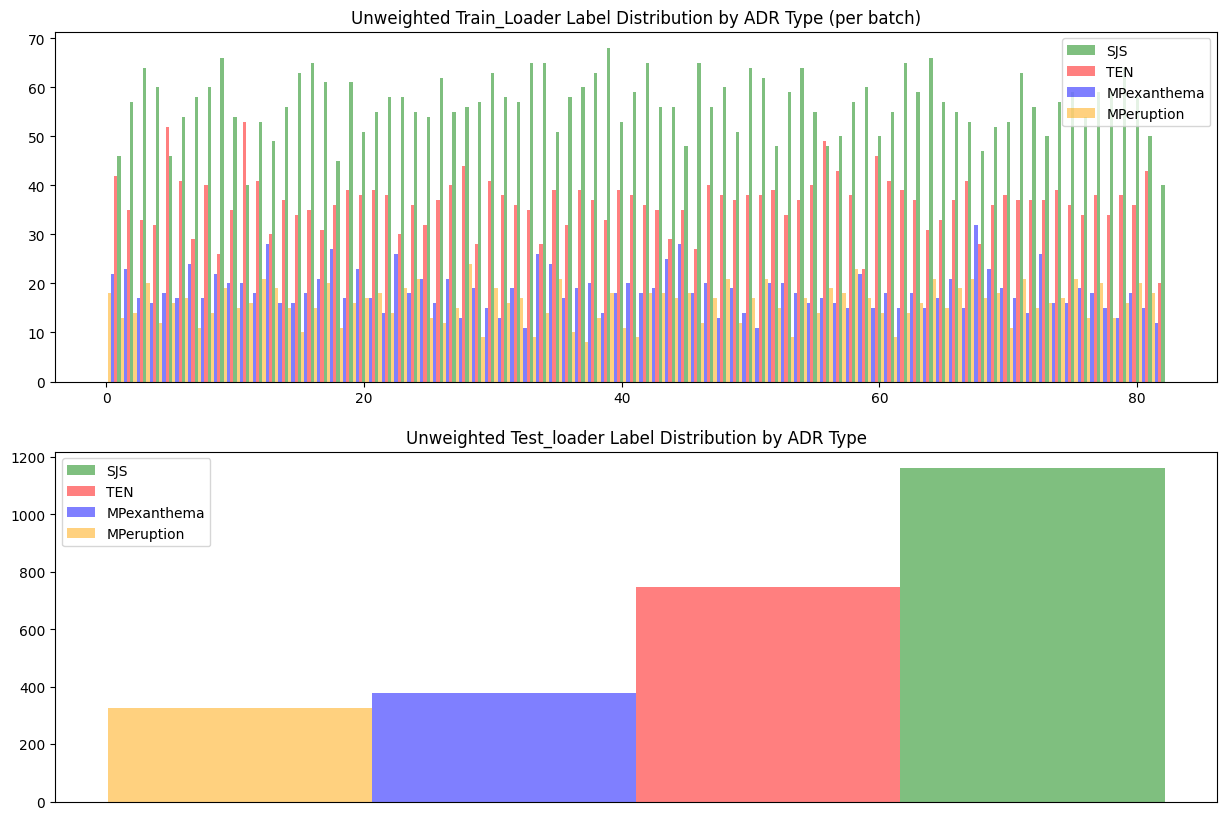

In [26]:
get_dataloader_distribution_manyclass(train_loader_unweight, test_loader_unweight, label = "Unweighted")

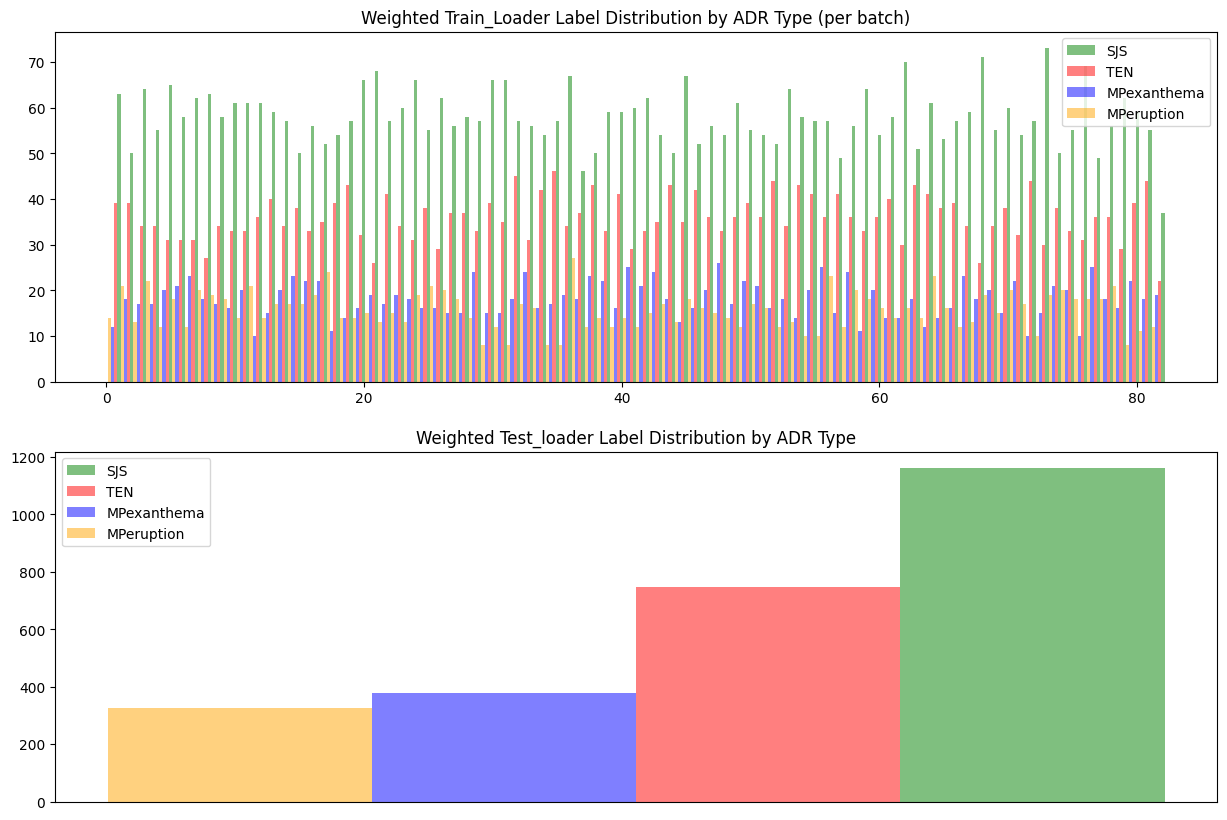

In [27]:
get_dataloader_distribution_manyclass(train_loader, test_loader, label = "Weighted")

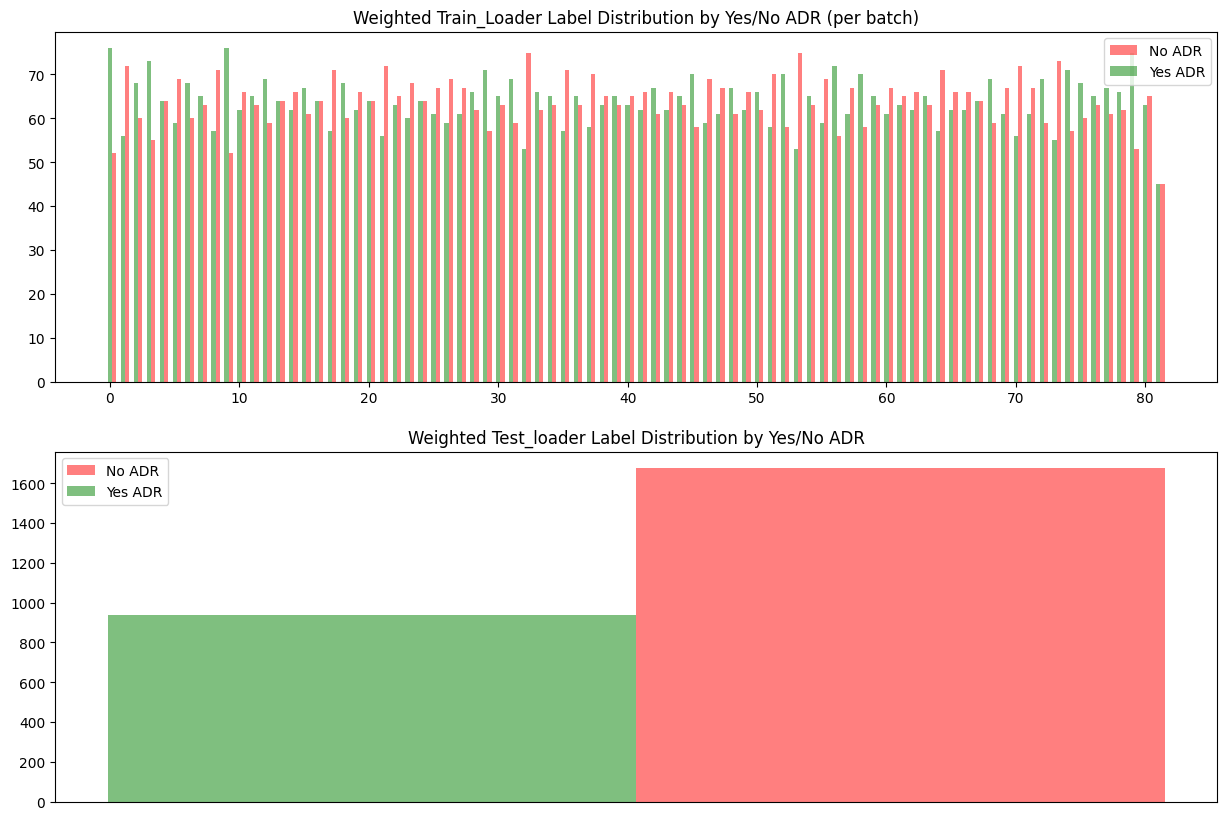

In [36]:
get_dataloader_distribution(train_loader, test_loader, label = "Weighted")

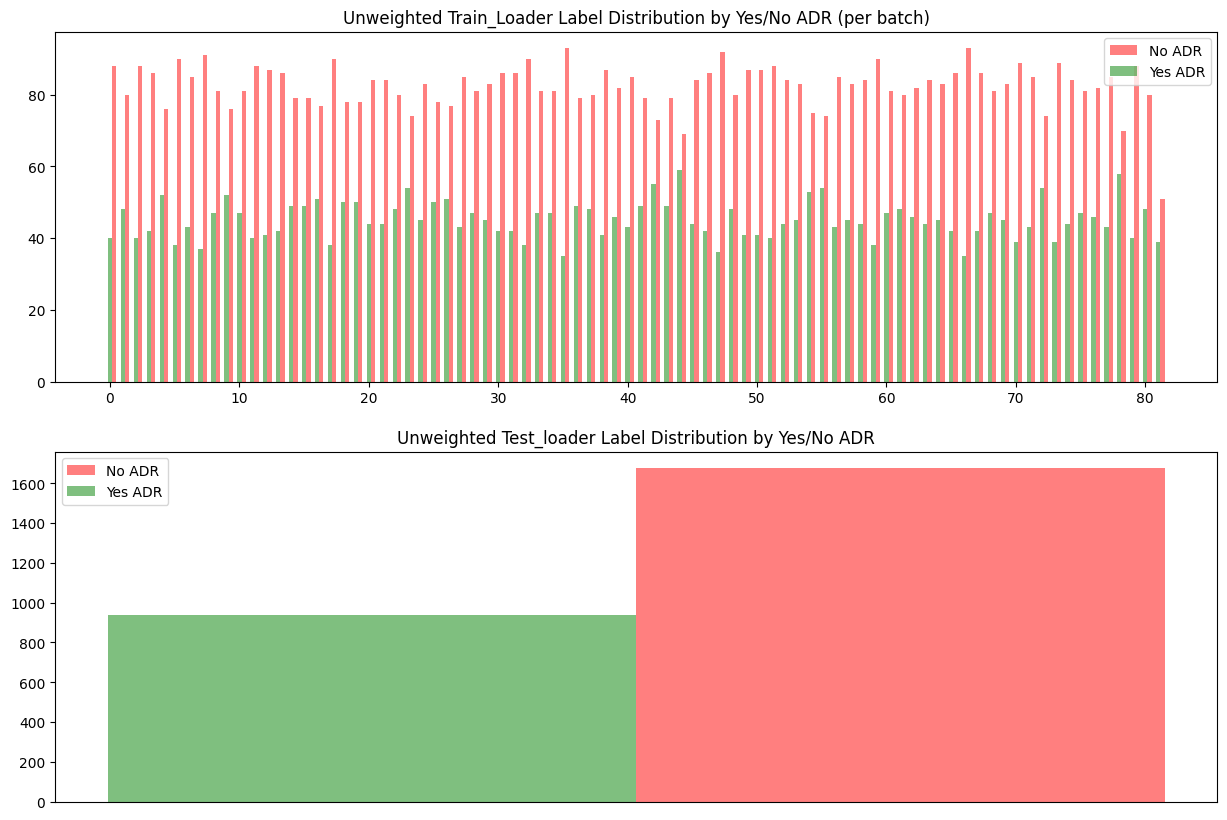

In [37]:
get_dataloader_distribution(train_loader_unweight, test_loader_unweight, label = "Unweighted")

## เอาข้อมูล ADR_TRACK ออกแล้วรันผ่าน Dataloaders ใหม่

In [382]:
np_input = np_input[:,1:]

In [383]:
train_loader, test_loader = get_dataloaders(128)

BEFORE applying weight train_label data distribution 0/1: 6762/3696
BEFORE applying weight test_labels data distribution 0/1: 1676/939


In [384]:
df_input.shape[1]

4364

In [385]:
np_input.shape[1]

4363

In [386]:
# Define Network Classes
class Network(nn.Module):
    def __init__(self, n_layers, n_first_units, dropout):
        super().__init__()

    # Define Layers    
        layers = []
        in_features = np_input.shape[1]
        out_features = n_first_units

        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        
        in_features = out_features

        for i in range(n_layers): #i หมายถึงเลขชั้น hidden+1

            layers.append(nn.BatchNorm1d(in_features))
            out_features = int(in_features/2)
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_features = out_features

        layers.append(nn.BatchNorm1d(out_features))
        layers.append(nn.Linear(out_features, 1)) 
        layers.append(nn.Sigmoid())


        self.layers = nn.Sequential(*layers)
        # self.layers = nn.Sequential(
        #     #Input Layer
        #     nn.Linear(df_input.shape[1],2048), 
        #     nn.ReLU(),
        #     nn.Dropout(0.2),

        #     #Hidden 1
        #     nn.BatchNorm1d(2048),
        #     nn.Linear(2048,1024),
        #     nn.ReLU(),
        #     nn.Dropout(0.2),

        #     #Hidden 2
        #     nn.BatchNorm1d(1024),
        #     nn.Linear(1024,512),
        #     nn.ReLU(),
        #     nn.Dropout(0.2),

            
        #     #Hidden 3
        #     nn.BatchNorm1d(512),
        #     nn.Linear(512,256),
        #     nn.ReLU(),
        #     nn.Dropout(0.2),

        #     #Hidden 4
        #     nn.BatchNorm1d(256),
        #     nn.Linear(256,128),
        #     nn.ReLU(),
        #     nn.Dropout(0.2),

        #     # #Hidden 3
        #     # nn.BatchNorm1d(512),
        #     # nn.Linear(512,256),
        #     # nn.ReLU(),
        #     # nn.Dropout(0.2),

        #     #Output Layer
        #     nn.Linear(256,1),
        #     nn.Sigmoid()
        # )

    # Define the forward pass
    def forward(self,input):
        output = self.layers(input)
        return output


In [387]:
# Empty CUDA cache
torch.cuda.empty_cache()

# Assign device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [388]:
# Define train function

def train(dataloader, model, loss_fn, optimizer):

    
    # Running Loss and Train Accuracy 
    running_loss = []
    running_train_acc = []

    # Set model to train mode
    model.train()

    # Loop through dataloader
    for batch_idx, (data, target) in enumerate(train_loader):

        # Move data to device
        data = data.float().to(device)
        target = target.float().to(device)
        
        # Save Model Graph
        if batch_idx == 0:
            dot = torchviz.make_dot(model(data), show_attrs=True, show_saved = True,params=dict(model.named_parameters()))
            dot.render(f'{dir}/{name}')

        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        
        # Calculate loss
        output = output.flatten()         
        loss = loss_fn(output,target)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Save loss for each batch
        running_loss.append(loss.item()) 

        # Calculate accuracy
        with torch.no_grad():
            target = target.flatten()
            output = torch.round(output)
            correct = (output == target).sum().item()
            train_acc = correct/len(target)
            train_acc = round(train_acc, 8)
            running_train_acc.append(train_acc)

    train_acc = np.mean(running_train_acc)
    train_loss = np.mean(running_loss)
    #print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    return float(train_loss), float(train_acc)

In [389]:
# Define test function

def test(dataloader, model, loss_fn):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):

            # Move data to device
            data = data.float().to(device)
            target = target.float().to(device)    
            
            # Forward pass           
            output = model(data)

            # Calculate loss
            output = output.flatten()
            data = data.flatten()
            
            test_loss = loss_fn(output, target)

            # Calculate accuracy
            output = torch.round(output)
            correct = (output == target).sum().item()

        output = output.cpu().detach().numpy()
        target = target.cpu().detach().numpy()

        # Calculate metrics
        test_acc = correct / len(test_loader.dataset)
        test_loss = test_loss.cpu().detach().numpy()
        test_precision = precision_score(output, target, zero_division=0)
        test_f1_score = f1_score(output, target, zero_division=0)
        test_recall_score = recall_score(output, target, zero_division=0)
    #print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall_score:.4f}, Test F1 Score: {test_f1_score:.4f}")

    return float(test_loss), float(test_acc), float(test_precision), float(test_recall_score), float(test_f1_score)